In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from random import randint
import matplotlib.pyplot as plt
import cv2

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('../input/labels.csv')
df_test = pd.read_csv('../input/sample_submission.csv')

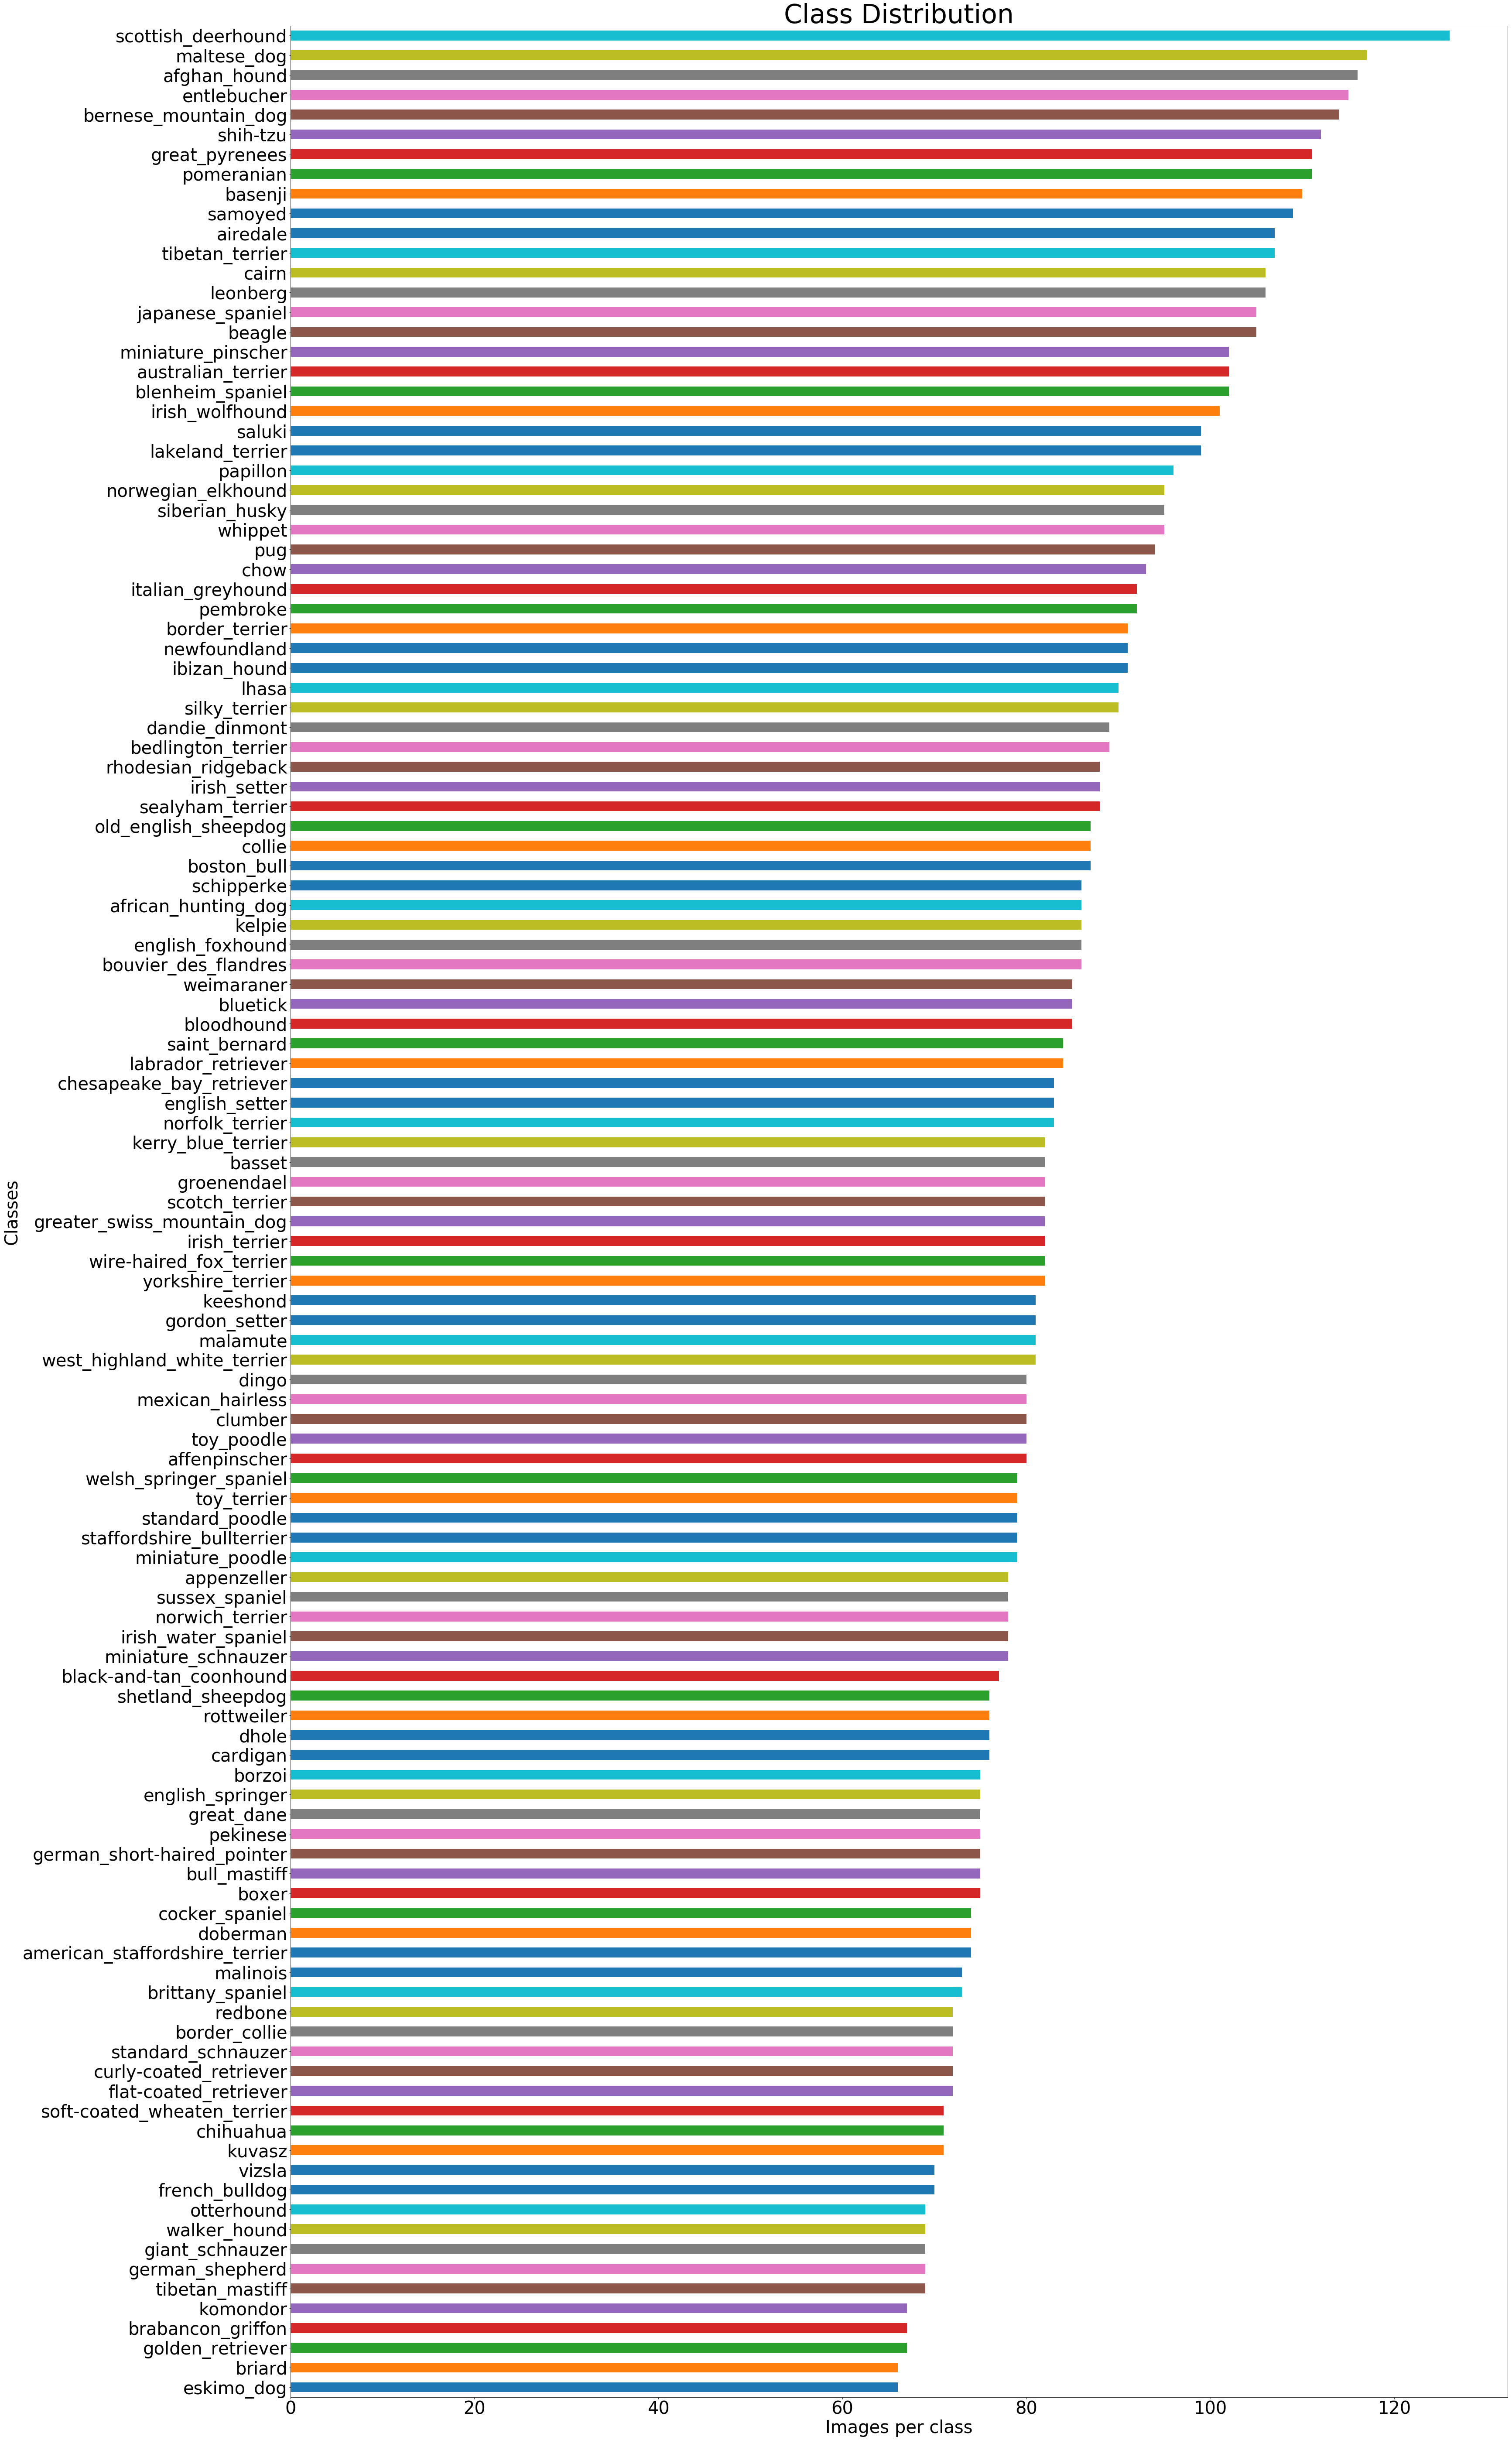

In [3]:
ax=pd.value_counts(df_train['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)

In [4]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [ ]:
one_hot_labels = np.asarray(one_hot)

In [ ]:
def read_and_resize_images(df,nrow=224,ncol=224,channels=3):
    from scipy import misc
    i = 0
    x = []
    y = []
    breeds = []
    for f, breed in tqdm(df.values):
        img = misc.imread('../input/train/{}.jpg'.format(f))
        label = one_hot_labels[i]
        x.append(misc.imresize(img, (nrow, ncol,channels)))
        y.append(label)
        breeds.append(breed)
        i += 1
    return x,y,breeds

In [ ]:
x_train,y_train,breeds_train = read_and_resize_images(df_train)

  0%|          | 0/10222 [00:00<?, ?it/s]C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10222/10222 [01:20<00:00, 127.71it/s]


In [ ]:
def read_and_resize_images_test(df,nrow=224,ncol=224,channels=3):
    from scipy import misc
    x = []
    for f in tqdm(df['id'].values):
        img = misc.imread('../input/test/{}.jpg'.format(f))
        x.append(misc.imresize(img, (nrow, ncol,channels)))
    return x

In [ ]:
x_test = read_and_resize_images_test(df_test)

  0%|          | 0/10357 [00:00<?, ?it/s]C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
 56%|█████▌    | 5814/10357 [01:13<01:05, 69.41it/s]

In [ ]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

In [ ]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(224,224,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    
    plt.show()

In [ ]:

random_numbers = [randint(0, len(x_train)) for p in range(0,9)]
x_train_to_show = [x_train[i] for i in random_numbers]
breeds_train_to_show = [breeds_train[i] for i in random_numbers]
print("Images to show: {0}".format(len(x_train_to_show)))
print("Classes to show: {0}".format(len(breeds_train_to_show)))

plot_images(x_train_to_show, breeds_train_to_show)

In [ ]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

In [ ]:
num_class = y_train_raw.shape[1]

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [ ]:
def prepareModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [ ]:
firstModel = prepareModel(num_class)
firstModel.summary()

In [ ]:
firstModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

In [ ]:
preds = firstModel.predict(x_test, verbose=1)

In [ ]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

In [ ]:
def prepareSecondModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers[:10]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [ ]:
secondModel = prepareSecondModel(num_class)
secondModel.summary()
secondModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

In [ ]:
preds = secondModel.predict(x_test, verbose=1)

In [ ]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

In [ ]:
def prepareThirdModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers[:10]:
        layer.trainable = False
        
    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [ ]:
thirdModel = prepareThirdModel(num_class)
thirdModel.summary()

In [ ]:
thirdModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

In [ ]:
preds = thirdModel.predict(x_test, verbose=1)

In [ ]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

In [ ]:
import mlflow.keras
mlflow.keras.save_model(firstModel, '.')